# Variational autoencoder (VAE)
It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.


In [21]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [22]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [23]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [24]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

opt = keras.optimizers.Adam(learning_rate=0.01)
vae.compile(optimizer='adam')

In [34]:
# Define the Required Callback Function
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint

class reduce_prints(keras.callbacks.Callback):
    def __init__(self, n_epoch):
        self.n_epoch = n_epoch
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.n_epoch ==0:
            print(f"Epoch {epoch}: Loss is: {logs['loss']}")

            
rp = reduce_prints(25)

In [26]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

history_vae = vae.fit(x_train, x_train,
        epochs=200,
        batch_size=512,
        validation_data=(x_test, x_test), verbose = 0, callbacks = [rp])

Epoch 0: Loss is: 311.3031005859375
Epoch 25: Loss is: 158.46542358398438
Epoch 50: Loss is: 153.025634765625
Epoch 75: Loss is: 150.31813049316406
Epoch 100: Loss is: 148.58924865722656
Epoch 125: Loss is: 147.522216796875
Epoch 150: Loss is: 146.66293334960938
Epoch 175: Loss is: 146.03285217285156


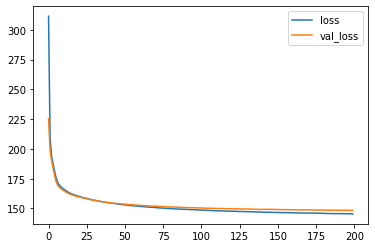

In [27]:
import matplotlib.pyplot as plt

plt.plot(history_vae.history['loss'])
plt.plot(history_vae.history['val_loss'])
plt.legend(['loss', 'val_loss'])

1    1135
2    1032
7    1028
dtype: int64


<AxesSubplot:>

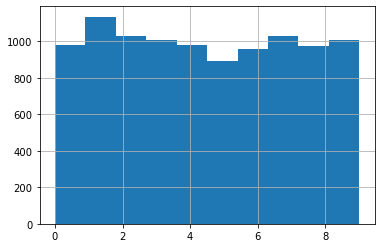

In [28]:
import pandas as pd

y_p = pd.Series(y_test)
print(y_p.value_counts().head(3))

y_p.hist()

 Total points to represent 10000


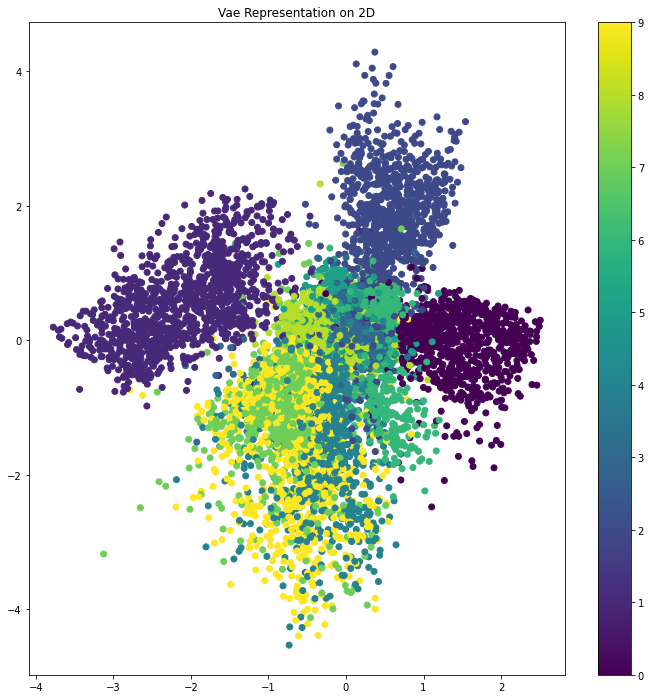

In [29]:
def create_VAE_representation(cut_point: int = x_test.shape[0]):
    x_test_encoded = encoder.predict(x_test[:cut_point], batch_size=9)
    print(f" Total points to represent {x_test_encoded[0].shape[0]}")
    plt.figure(figsize=(12, 12))
    plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=y_test[:cut_point])
    plt.colorbar()
    plt.title('Vae Representation on 2D')
    plt.show()
    

create_VAE_representation()

## Comparison with PCA

shape of pca_reduced.shape =  (10000, 2)


C:\Users\f.gonzalez\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


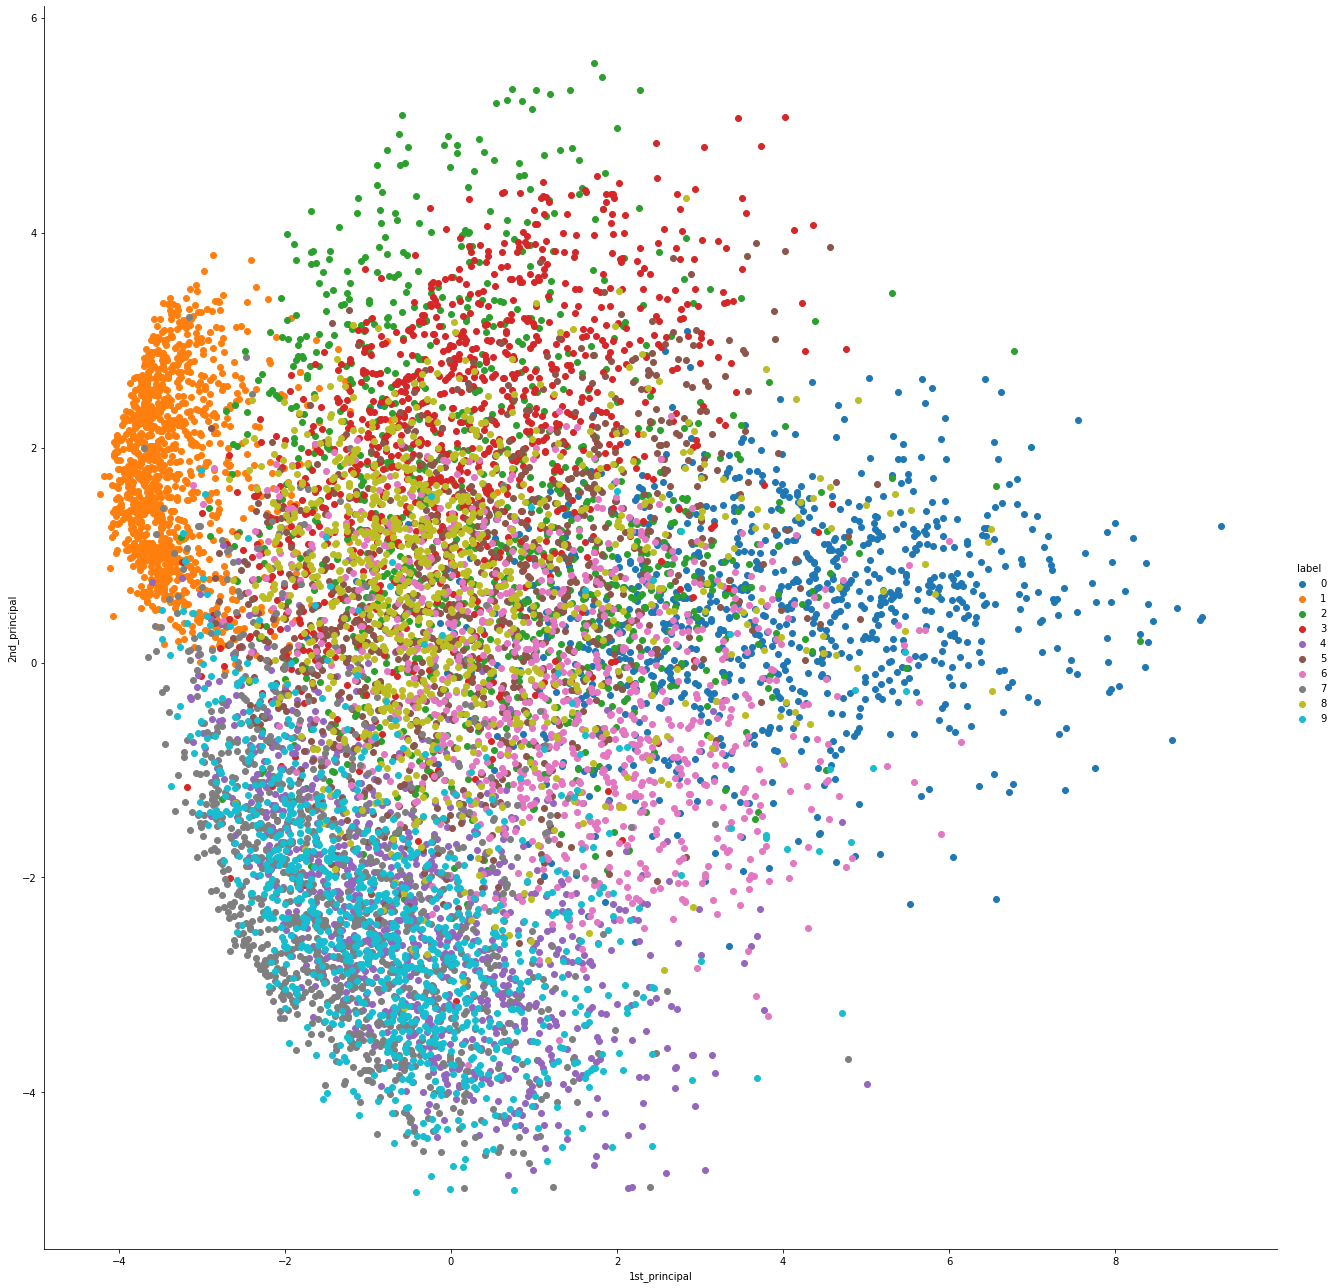

In [30]:
def create_PCA(cut_point: int = x_test.shape[0]):
    from sklearn import decomposition
    pca=decomposition.PCA()
    pca.n_components = 2
    pca_data = pca.fit_transform(x_test[:cut_point])
    print("shape of pca_reduced.shape = ", pca_data.shape)
    pca_data = np.vstack((pca_data.T, y_test[:cut_point])).T
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
    pca_df["label"]  = pca_df["label"].astype(int)
    import seaborn as sns
    sns.FacetGrid(pca_df, hue="label", size=18).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.show()
    
create_PCA()

shape of pca_reduced.shape =  (2000, 2)


C:\Users\f.gonzalez\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


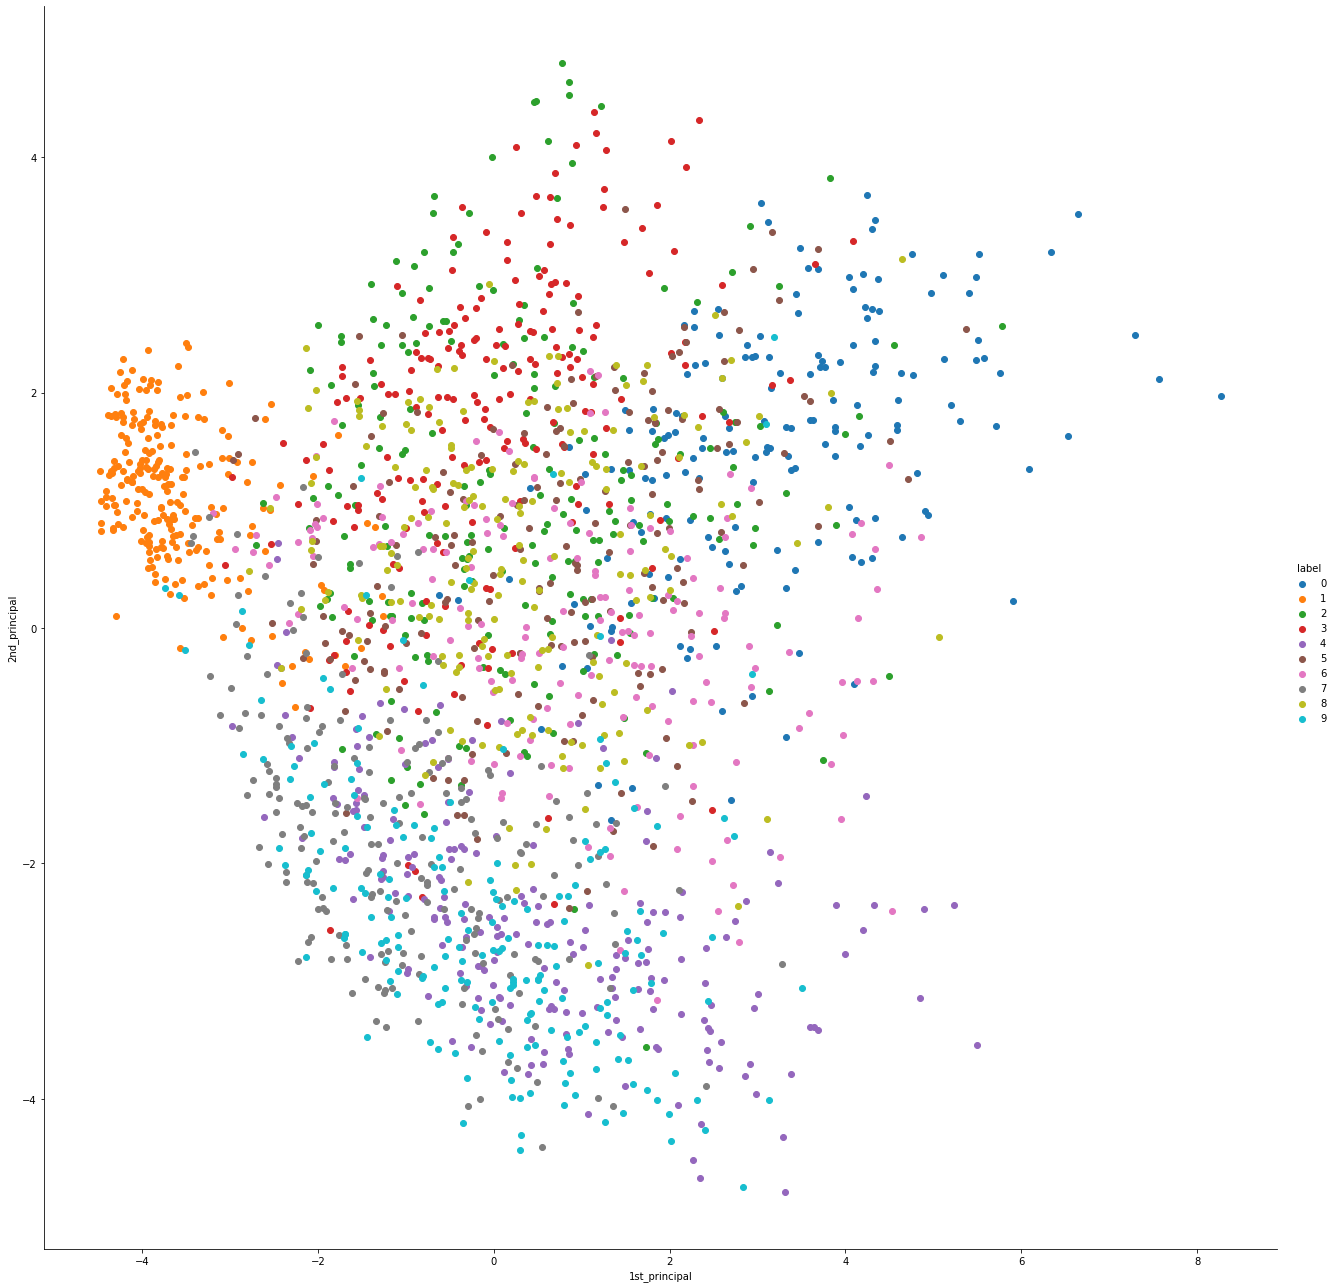

In [31]:
create_PCA(2000)

 Total points to represent 2000


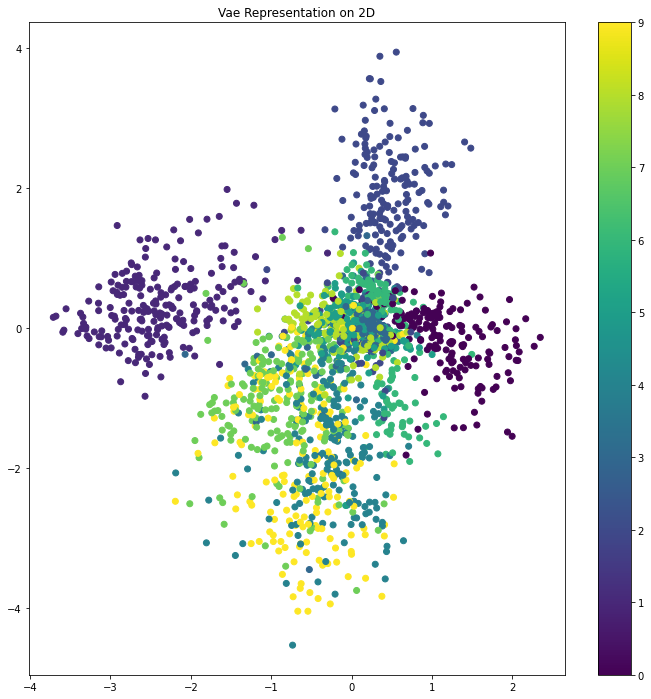

In [32]:
create_VAE_representation(2000)

As we can see from the graphs above, when we are using the whole testing set is difficult to distinguish and see something clearly. But, when we use less samples to study the degree of separability we can see results from VAE are way better than with PCA. 
This might be because PCA assumes a linear relationship between features. The algorithm is not well suited to capturing non-linear relationships. That’s why it’s advised to turn non-linear features or relationships between features into linear, using the standard methods such as log transforms. So, maybe PCA is not a robust algorithm to be compared to.

## Comparison with TSNE. 

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [ ]:
from sklearn.manifold import TSNE

In [35]:
x_tsne = TSNE(n_components=2).fit_transform(X)

(10000, 784)

shape of pca_reduced.shape =  (10000, 2)


C:\Users\f.gonzalez\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


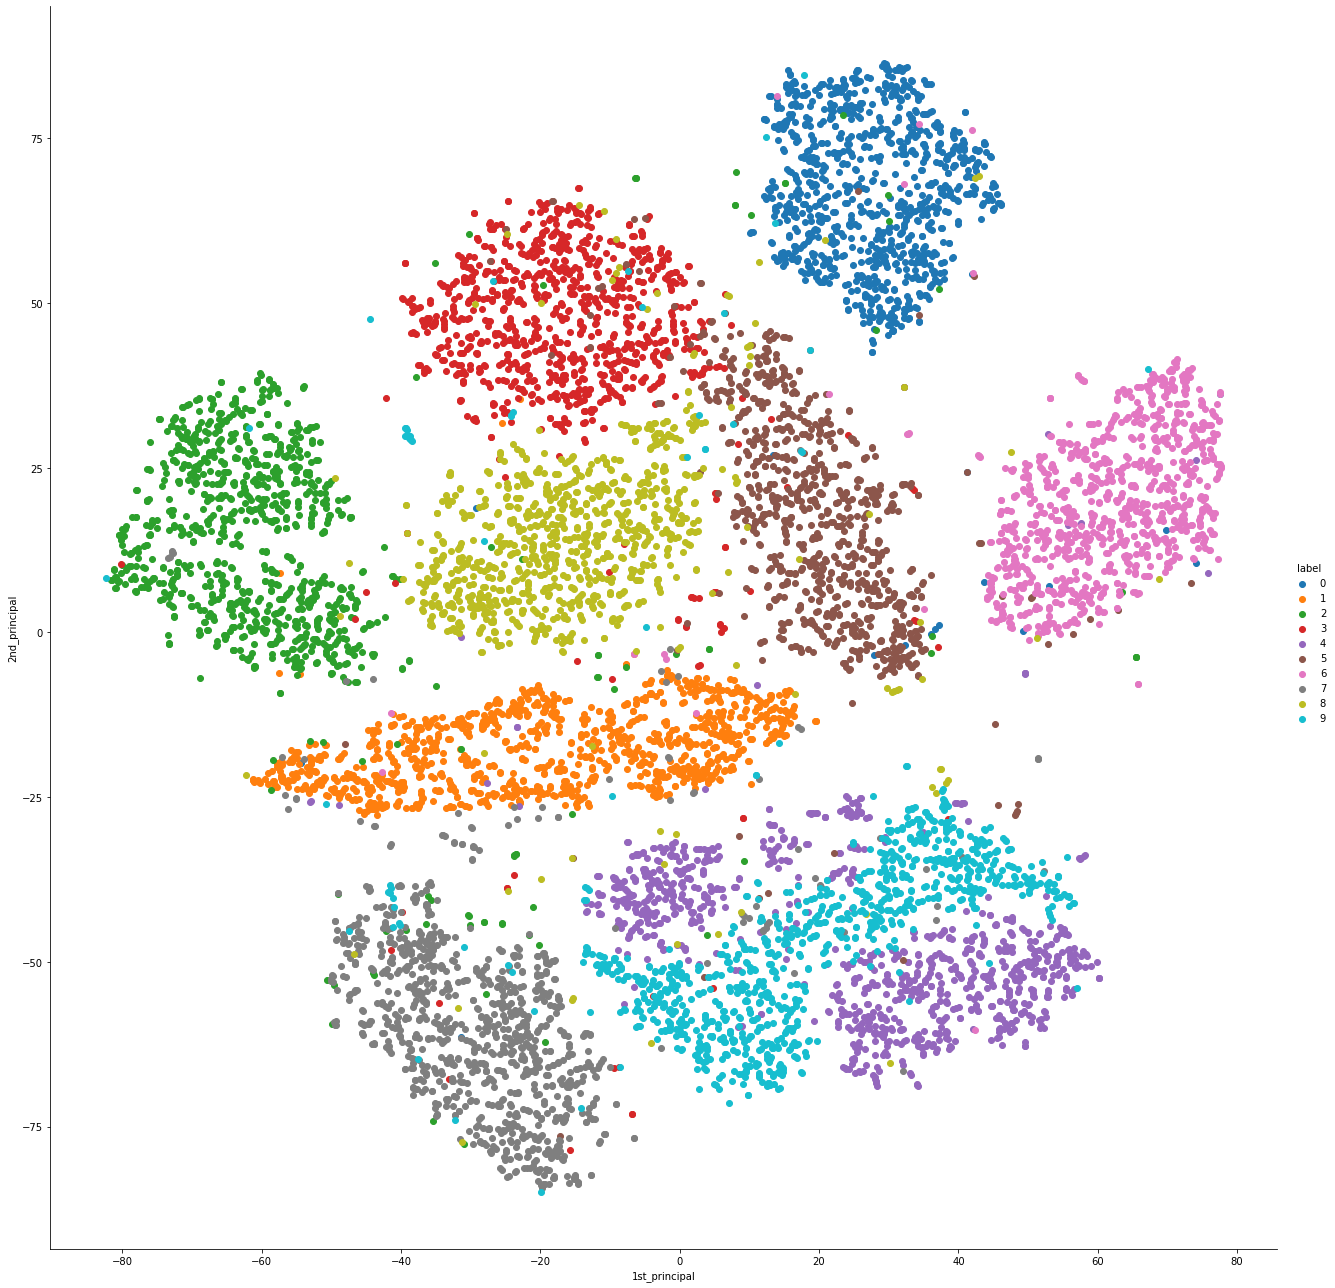

In [38]:
def create_TSNE(cut_point: int = x_test.shape[0]):
    from sklearn.manifold import TSNE
    tsne_data = TSNE(n_components=2).fit_transform(x_test[:cut_point])
    print("shape of pca_reduced.shape = ", tsne_data.shape)
    tsne_data = np.vstack((tsne_data.T, y_test[:cut_point])).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "label"))
    tsne_df["label"]  = tsne_df["label"].astype(int)
    import seaborn as sns
    sns.FacetGrid(tsne_df, hue="label", size=18).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.show()
    
create_TSNE()

Ok, it seems that we have a clear winner.

shape of pca_reduced.shape =  (2000, 2)


C:\Users\f.gonzalez\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


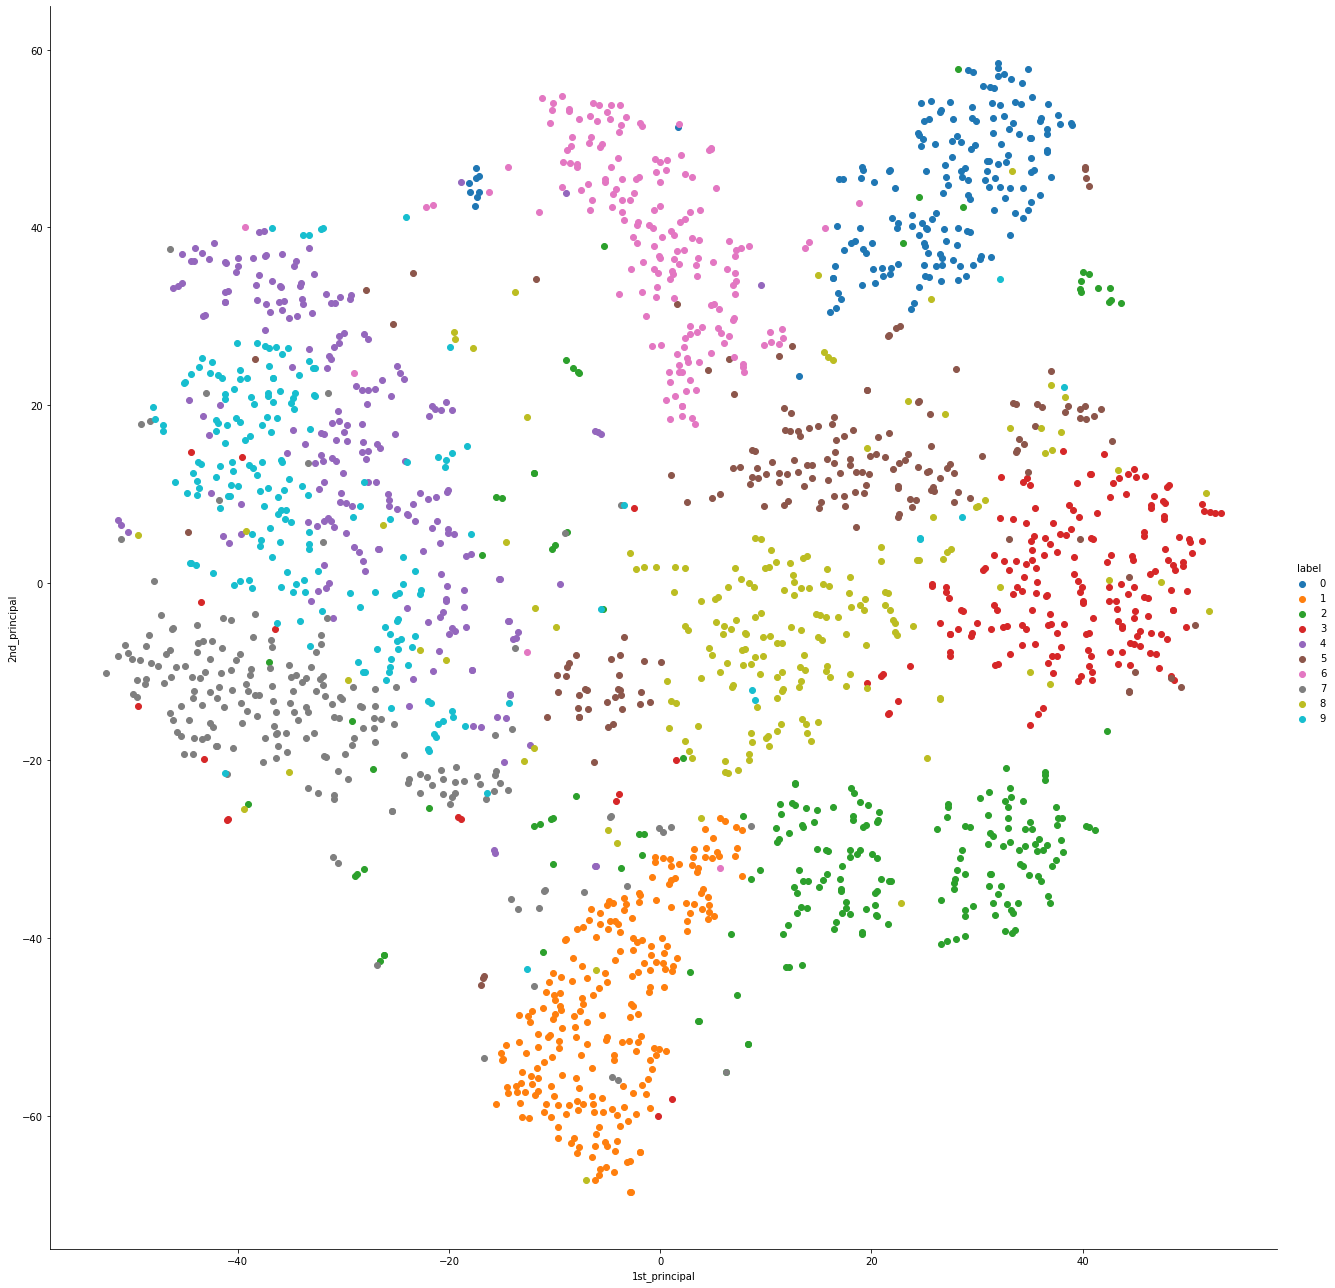

In [39]:
create_TSNE(2000)